## Importing Modules

In [28]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") # this will take away the red dialog boxes in the output terminal

## Reading Data

In [29]:
training_data = pd.read_csv('Capstone #2 training data.csv') # First mentor meeting, don't specify the 'r' mode otherwise data will be a mess
testing_data = pd.read_csv('Capstone #2 test data.csv')

In [30]:
testing_data.head() # Testing data has no target variable, so it cannot be used.  However, a prediction can be made with the models created.

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


## Wrangling The Data

In [31]:
training_data['Loan_Status'].replace('Y', '1', inplace=True) # Quantized loan status into 1 from yes and 0 from no.
training_data['Loan_Status'].replace('N', '0', inplace=True)

In [32]:
training_data['Gender'].fillna(training_data['Gender'].mode()[0], inplace = True)  # Imputed the mode for these six features based on EDA exploration
training_data['Married'].fillna(training_data['Married'].mode()[0], inplace = True)
training_data['Dependents'].fillna(training_data['Dependents'].mode()[0], inplace = True)
training_data['Credit_History'].fillna(training_data['Credit_History'].mode()[0], inplace = True)
training_data['Self_Employed'].fillna(training_data['Self_Employed'].mode()[0], inplace = True)
training_data['Loan_Amount_Term'].fillna(training_data['Loan_Amount_Term'].mode()[0], inplace = True) 
training_data['LoanAmount'].fillna(training_data['LoanAmount'].median(), inplace = True) # Imputing median for LoanAmount missing values.

In [33]:
training_data['Education'].replace('Graduate', '1', inplace=True) # Quantizing Education like was done with target variable.
training_data['Education'].replace('Not Graduate', '0', inplace=True)

training_data['Self_Employed'].replace('Yes', '1', inplace=True) # Quantizing Self_Employed like was done with target variable.
training_data['Self_Employed'].replace('No', '0', inplace=True)

training_data['Gender'].replace('Male', '1', inplace=True) # Quantizing Gender like was done with target variable.
training_data['Gender'].replace('Female', '0', inplace=True)

training_data['Married'].replace('Yes', '1', inplace=True) # Quantizing Married like was done with target variable.
training_data['Married'].replace('No', '0', inplace=True)

training_data['Dependents'].replace('3+', '3', inplace=True) # Fully quantized all Dependents.values so that this feature is numerical.

training_data['Property_Area'].replace('Rural', '0', inplace=True) # Quantized Property Area based on values.
training_data['Property_Area'].replace('Semiurban', '1', inplace=True) # Imputed values oriented so that extent of urbanization
training_data['Property_Area'].replace('Urban', '2', inplace=True) # can be presented as a spectrum.

In [34]:
training_data['Property_Area'] = training_data['Property_Area'].astype("float64")
training_data['Loan_Status'] = training_data['Loan_Status'].astype("float64") # Changing types
training_data['Dependents'] = training_data['Dependents'].astype("float64")
training_data['Education'] = training_data['Education'].astype("float64")
training_data['Self_Employed'] = training_data['Self_Employed'].astype("float64")
training_data['Gender'] = training_data['Gender'].astype("float64")
training_data['Married'] = training_data['Married'].astype("float64")

## Feature Engineering

In [35]:
bins = [0, 2500, 4000, 6000, 81000]
group = ['Low', 'Average', 'High', 'Very High']
training_data['Total_Income_bin'] = training_data['ApplicantIncome'] + training_data['CoapplicantIncome']
training_data['Total_Income_bin'] = pd.cut(training_data['Total_Income_bin'], bins, labels = group)

In [36]:
training_data = training_data.drop(['Loan_ID', 'ApplicantIncome', 'CoapplicantIncome'], axis=1) # Dropping columns

In [37]:
training_data['Total_Income_bin'].replace('Low', '0', inplace=True)
training_data['Total_Income_bin'].replace('Average', '1', inplace=True)
training_data['Total_Income_bin'].replace('High', '2', inplace=True)
training_data['Total_Income_bin'].replace('Very High', '3', inplace=True)
training_data['Total_Income_bin'] = training_data['Property_Area'].astype("float64")
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Gender            614 non-null    float64
 1   Married           614 non-null    float64
 2   Dependents        614 non-null    float64
 3   Education         614 non-null    float64
 4   Self_Employed     614 non-null    float64
 5   LoanAmount        614 non-null    float64
 6   Loan_Amount_Term  614 non-null    float64
 7   Credit_History    614 non-null    float64
 8   Property_Area     614 non-null    float64
 9   Loan_Status       614 non-null    float64
 10  Total_Income_bin  614 non-null    float64
dtypes: float64(11)
memory usage: 52.9 KB


## Splitting Up the Training Data Into X and y

In [38]:
X = training_data.drop(['Loan_Status'], axis=1)
y = training_data['Loan_Status']

## Defining LogisticRegression And RandomForest Models

In [39]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

def run_regression_accuracy(X_train, y_train, X_test, y_test):   
    paramgrid = {'C': np.logspace(-8, 5, 15)}
    grid_search = GridSearchCV(LogisticRegression(), paramgrid)
    
    grid_search.fit(X_train, y_train)
    logreg = grid_search.best_estimator_
    y_pred = logreg.predict(X_test)
    print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
    cm = confusion_matrix(y_test, y_pred)
    print('\nConfusion matrix: \n',cm)

    print('\nClassification report: \n',classification_report(y_test, y_pred))

    logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])

    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('LOGISTIC REGRESSION RESULTS.png')
    plt.show()
  
    return logreg

In [40]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

def run_random_forest_accuracy(X_train, y_train, X_test, y_test):   
    paramgrid = {'max_depth': list(range(1, 20, 2)), 'n_estimators': list(range(1, 200, 20))}
    grid_search = RandomizedSearchCV(RandomForestClassifier(random_state=1), paramgrid) # Could do a RandomizedSearchCV to save computing.
    
    grid_search.fit(X_train, y_train)
    logreg = grid_search.best_estimator_
    y_pred = logreg.predict(X_test)
    print('Accuracy of random forest classifier on test set: {:.2f}'.format(logreg.score(X_test, y_test)))
    cm = confusion_matrix(y_test, y_pred)
    print('\nConfusion matrix: \n',cm)

    print('\nClassification report: \n',classification_report(y_test, y_pred))

    logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
    fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])

    plt.figure()
    plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.savefig('RANDOM FOREST RESULTS.png')
    plt.show()
  
    return logreg

## Splitting The Data Into Training And Testing Sets

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Specifying Shap Values

In [42]:
import shap

## The best logistic regression model

Accuracy of logistic regression classifier on test set: 0.78

Confusion matrix: 
 [[ 27  38]
 [  2 118]]

Classification report: 
               precision    recall  f1-score   support

         0.0       0.93      0.42      0.57        65
         1.0       0.76      0.98      0.86       120

    accuracy                           0.78       185
   macro avg       0.84      0.70      0.71       185
weighted avg       0.82      0.78      0.76       185



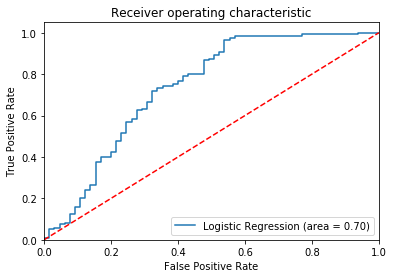

In [43]:
explainer = shap.LinearExplainer(run_regression_accuracy(X_train, y_train, X_test, y_test), X_train, feature_dependence="independent")
shap_values = explainer.shap_values(X_train)

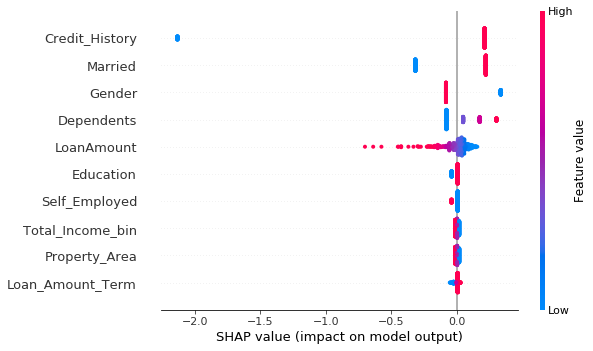

In [44]:
shap.summary_plot(shap_values, X_train)

## The best random forest model

Accuracy of random forest classifier on test set: 0.78

Confusion matrix: 
 [[ 27  38]
 [  2 118]]

Classification report: 
               precision    recall  f1-score   support

         0.0       0.93      0.42      0.57        65
         1.0       0.76      0.98      0.86       120

    accuracy                           0.78       185
   macro avg       0.84      0.70      0.71       185
weighted avg       0.82      0.78      0.76       185



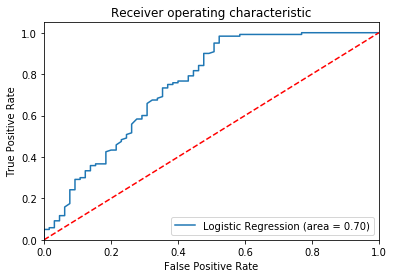

In [45]:
explainer = shap.TreeExplainer(run_random_forest_accuracy(X_train, y_train, X_test, y_test), X_train, feature_dependence="independent")
shap_values_random_forest = explainer.shap_values(X_train)

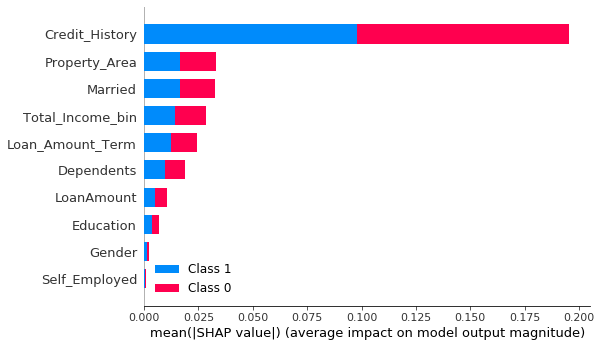

In [46]:
shap.summary_plot(shap_values_random_forest, X_train, plot_type = "bar")